<a href="https://colab.research.google.com/github/Kryptera-K/BIIB-Gann-Hi-Lo-Pullback-with-Bollinger-Volatility-Strategy/blob/main/BIIB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "BIIB"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("BIIB_clean.csv", index=False)
df

/tmp/ipython-input-4231362086.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,31.083332,32.833332,28.645832,32.791668,2792700
2000-01-04,28.979168,30.916668,28.583332,29.875000,2935500
2000-01-05,31.000000,31.500000,25.000000,28.708332,3390000
2000-01-06,32.375000,32.833332,29.666668,30.166668,2742300
2000-01-07,36.104168,36.166668,32.333332,32.333332,4736400
...,...,...,...,...,...
2025-12-15,175.740005,175.940002,170.449997,173.669998,2291500
2025-12-16,171.500000,174.509995,169.520004,174.509995,2408300
2025-12-17,172.100006,173.830002,169.550003,171.429993,2783500


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BB_PERIOD = 20
BB_STD = 2
GANN_SHIFT = 1

# -------------------------
# Indicator Functions
# -------------------------

def gann_open_below_highest_after_below(df, shift=GANN_SHIFT):
    df = calculate_gann_trend(df, shift)
    return (df['Open'] < df['Prev_High']) & (df['Prev_Open'] < df['Prev_High'])


def calculate_gann_trend(df, shift=GANN_SHIFT):
    """
    Calculate Gann Hi-Lo Trend and reference bars.
    """
    df = df.copy()
    # Previous bar high/low/open
    df['Gann_High'] = df['High'].shift(shift)
    df['Gann_Low'] = df['Low'].shift(shift)
    df['Prev_High'] = df['High'].shift(shift)
    df['Prev_Low'] = df['Low'].shift(shift)
    df['Prev_Open'] = df['Open'].shift(shift)

    # Trend
    df['Gann_UpTrend'] = df['Close'] > df['Gann_Low']
    df['Gann_DownTrend'] = df['Close'] < df['Gann_High']

    return df


def bb_open_above_upper(df, period=BB_PERIOD, std_multiplier=BB_STD):
    df = calculate_bollinger_bands(df, period, std_multiplier)
    return df['Open'] > df['BB_Upper']


def calculate_bollinger_bands(df, period=BB_PERIOD, std_multiplier=BB_STD):
    """
    Calculate Bollinger Bands: Middle, Upper, and Lower.
    """
    df = df.copy()
    df['BB_MA'] = df['Close'].rolling(window=period).mean()
    df['BB_Upper'] = df['BB_MA'] + std_multiplier * df['Close'].rolling(window=period).std()
    df['BB_Lower'] = df['BB_MA'] - std_multiplier * df['Close'].rolling(window=period).std()
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Open_Below_Highest_after_Below"] = gann_open_below_highest_after_below(df)

# -------------------------
# Exit conditions
# -------------------------

df["BB_Open_Above_Upper"] = bb_open_above_upper(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Open_Below_Highest_after_Below',
]
exit_conditions = [
    'BB_Open_Above_Upper',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-12-19 00:00:00
Period                                6532 days 00:00:00
Start Value                                     100000.0
End Value                                  671183.999164
Total Return [%]                              571.183999
Benchmark Return [%]                          422.449811
Max Gross Exposure [%]                             100.0
Total Fees Paid                            119810.316825
Max Drawdown [%]                                75.93876
Max Drawdown Duration                 2699 days 00:00:00
Total Trades                                          74
Total Closed Trades                                   73
Total Open Trades                                      1
Open Trade PnL                             124593.022072
Win Rate [%]                                    58.90411
Best Trade [%]                                144.826027
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-19 00:00:00
Period                         6532 days 00:00:00
Start Value                              100000.0
End Value                           522449.811479
Total Return [%]                       422.449811
Benchmark Return [%]                   422.449811
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        76.821736
Max Drawdown Duration          2705 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                      422449.811479
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


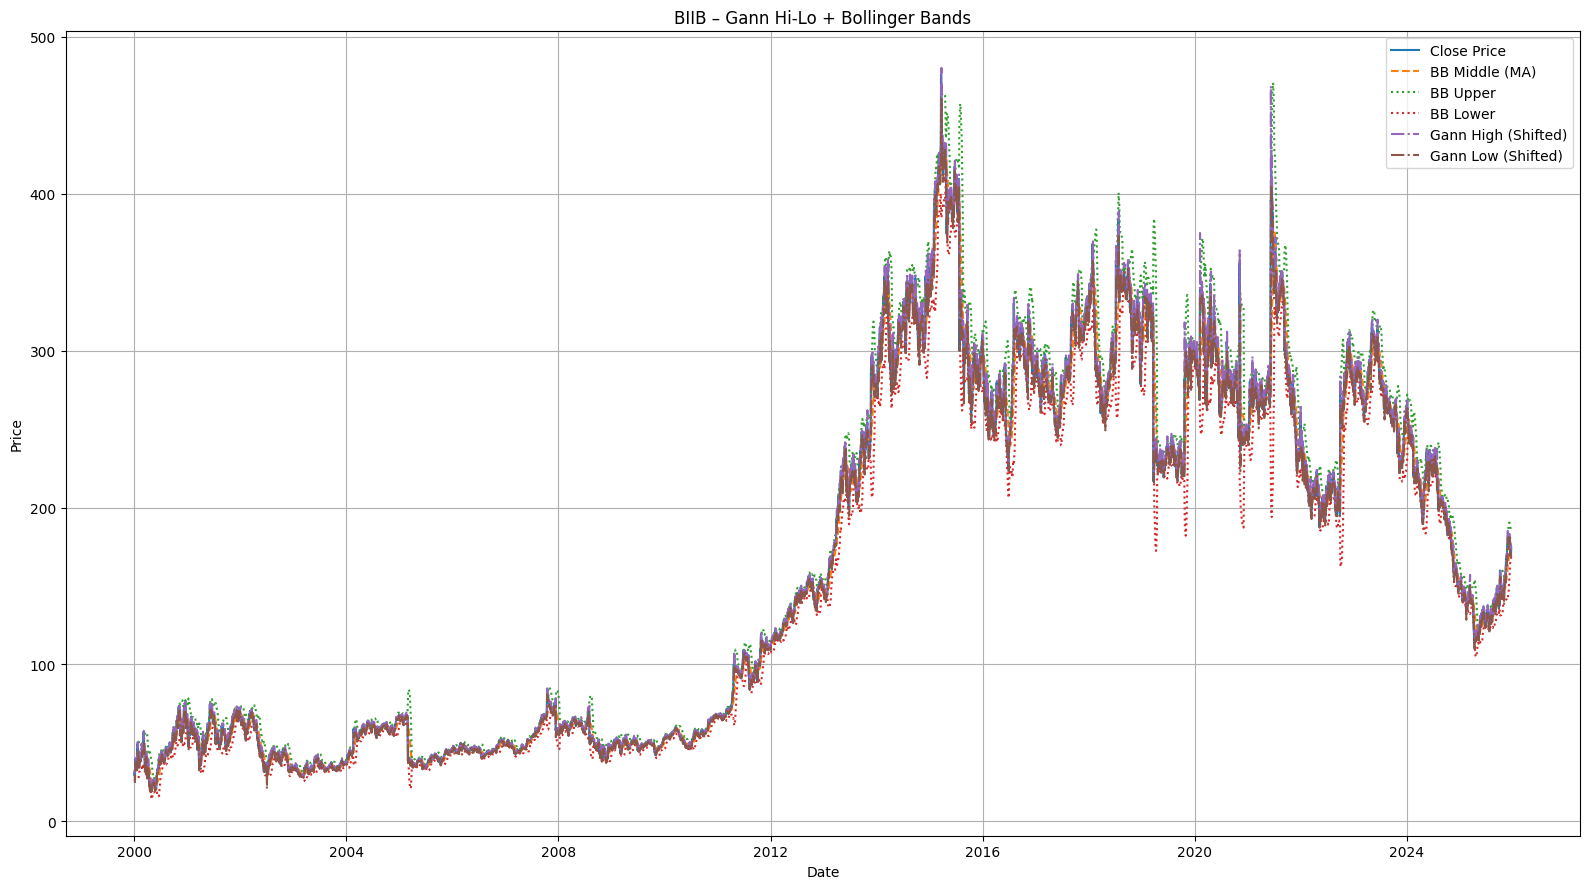

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------------------------
# Calculate all indicators
# -------------------------------------------------

df_ind = df.copy()

# Gann
df_ind = calculate_gann_trend(df_ind, shift=GANN_SHIFT)

# Bollinger Bands
df_ind = calculate_bollinger_bands(df_ind, period=BB_PERIOD, std_multiplier=BB_STD)

# Signals (optional)
df_ind["Gann_Open_Below_High"] = gann_open_below_highest_after_below(df_ind)
df_ind["BB_Open_Above_Upper"] = bb_open_above_upper(df_ind)


plt.figure(figsize=(16, 9))

# -------------------------
# Price
# -------------------------
plt.plot(df_ind.index, df_ind["Close"], label="Close Price", linewidth=1.5)

# -------------------------
# Bollinger Bands
# -------------------------
plt.plot(df_ind.index, df_ind["BB_MA"], label="BB Middle (MA)", linestyle="--")
plt.plot(df_ind.index, df_ind["BB_Upper"], label="BB Upper", linestyle=":")
plt.plot(df_ind.index, df_ind["BB_Lower"], label="BB Lower", linestyle=":")

# -------------------------
# Gann Hi-Lo Levels
# -------------------------
plt.plot(df_ind.index, df_ind["Gann_High"], label="Gann High (Shifted)", linestyle="-.")
plt.plot(df_ind.index, df_ind["Gann_Low"], label="Gann Low (Shifted)", linestyle="-.")

# -------------------------
# Chart Settings
# -------------------------
plt.title(f"{symbol} – Gann Hi-Lo + Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
